# Predicting the stock prices of Petrobras

In this notebook we will use the DeepAR algorithm from AWS SageMaker to predict the values of the stock prices of Petrobras, the historical data was taken from: https://br.investing.com/equities/petrobras-pn-historical-data

# Feature Engineering

In [3]:
#Import the libraries that will be used

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import json
import os
import numpy as np
import datetime

In [8]:
# Import the dataset

df = pd.read_csv('PETR4-Dados-Históricos.csv')
df

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,20.06.2022,"27,73","26,02","28,22","25,93","86,07M","1,54%"
1,17.06.2022,"27,31","28,17","28,45","26,13","183,27M","-6,09%"
2,15.06.2022,"29,08","30,00","30,02","28,84","72,19M","-1,76%"
3,14.06.2022,"29,60","29,66","30,25","29,24","68,57M","1,13%"
4,13.06.2022,"29,27","29,02","29,58","28,67","64,36M","-1,28%"
...,...,...,...,...,...,...,...
1252,26.05.2017,"13,12","12,92","13,23","12,86","63,10M","-0,46%"
1253,25.05.2017,"13,18","13,40","13,61","13,08","44,84M","-1,42%"
1254,24.05.2017,"13,37","13,19","13,52","13,13","53,98M","3,32%"
1255,23.05.2017,"12,94","12,90","13,05","12,84","48,35M","0,62%"


In [10]:
# Converting the first columns to a data-type format

from datetime import datetime
dateparse = lambda dates: datetime.strptime(dates, '%d.%m.%Y')
base = pd.read_csv('PETR4-Dados-Históricos.csv', parse_dates = ['Data'], index_col = 'Data', date_parser = dateparse)
base

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2022-06-20,"27,73","26,02","28,22","25,93","86,07M","1,54%"
2022-06-17,"27,31","28,17","28,45","26,13","183,27M","-6,09%"
2022-06-15,"29,08","30,00","30,02","28,84","72,19M","-1,76%"
2022-06-14,"29,60","29,66","30,25","29,24","68,57M","1,13%"
2022-06-13,"29,27","29,02","29,58","28,67","64,36M","-1,28%"
...,...,...,...,...,...,...
2017-05-26,"13,12","12,92","13,23","12,86","63,10M","-0,46%"
2017-05-25,"13,18","13,40","13,61","13,08","44,84M","-1,42%"
2017-05-24,"13,37","13,19","13,52","13,13","53,98M","3,32%"


In [11]:
# We will use the closing values as the parameter of the time series, so we can drop all the other columns

base.drop(columns = ['Abertura', 'Máxima', 'Mínima', 'Vol.','Var%'], axis = 1, inplace = True)

In [12]:
# No we will substitute the commas in the column to dots

base = base.applymap(lambda x: str(x.replace(',','.')))

In [15]:
# Converting the values of the column to float type

base["Último"] = base["Último"].astype(str).astype(float)
base.dtypes

Último    float64
dtype: object

In [16]:
# Notice that the dates are inverted, so we will rever the order of the time series
base = base.iloc[::-1]
base

,Último
Data,
2017-05-22,12.86
2017-05-23,12.94
2017-05-24,13.37
2017-05-25,13.18
2017-05-26,13.12
...,...
2022-06-13,29.27
2022-06-14,29.60
2022-06-15,29.08


In [17]:
# Creating the training and test bases. 
# For the training base we will take the same time series minus 30 days
# For the test base we will take the entire time series

base_treinamento = base.iloc[0:1227,:]
base_teste = base.copy()

In [18]:
base_treinamento.shape, base_teste.shape

((1227, 1), (1257, 1))

In [19]:
# Finding the first and last day in the training base

base_treinamento.index.min(), base_treinamento.index.max()

(Timestamp('2017-05-22 00:00:00'), Timestamp('2022-05-06 00:00:00'))

In [20]:
# Finding the first and last day in the test base

base_teste.index.min(), base_teste.index.max()

(Timestamp('2017-05-22 00:00:00'), Timestamp('2022-06-20 00:00:00'))

In [21]:
# Defining the initial and final points of the training and test ...
# ... and then defining the time span of the two bases

dt_data_inicial = pd.Timestamp("2017-05-22", freq = 'D')
dt_data_final_treinamento = pd.Timestamp("2022-05-06", freq = 'D')
dt_previsao_maxima = pd.Timestamp("2022-06-20", freq = 'D')

faixa_treinamento = (dt_data_inicial, dt_data_final_treinamento)
faixa_teste = (dt_data_inicial, dt_previsao_maxima)

In [22]:
faixa_treinamento, faixa_teste

((Timestamp('2017-05-22 00:00:00', freq='D'),
  Timestamp('2022-05-06 00:00:00', freq='D')),
 (Timestamp('2017-05-22 00:00:00', freq='D'),
  Timestamp('2022-06-20 00:00:00', freq='D')))

In [23]:
# Creating the lists of the time series

serie_temporal_treinamento = []
serie_temporal_teste = []

serie_temporal_treinamento.append(base_treinamento[faixa_treinamento[0]:faixa_treinamento[1]]['Último'])
serie_temporal_teste.append(base_teste[faixa_teste[0]:faixa_teste[1]]['Último'])

In [24]:
type(serie_temporal_treinamento), type(serie_temporal_teste)

(list, list)

In [25]:
len(serie_temporal_treinamento[0]), len(serie_temporal_teste[0])

(1227, 1257)

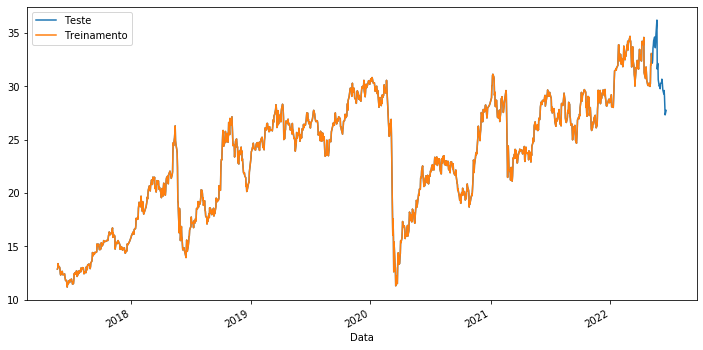

In [68]:
# Plotting the training and test time series

plt.figure(figsize=(12,6))
serie_temporal_teste[0].plot(label = "Teste")
serie_temporal_treinamento[0].plot(label = "Treinamento")
plt.legend()
plt.show()

In [28]:
# Encoding and converting the time series to json files (the required format from the DeepAR)

def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]

In [29]:
encode_target(serie_temporal_treinamento[0][0:5])

[12.86, 12.94, 13.37, 13.18, 13.12]

In [30]:
def series_to_obj(ts):
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    return obj

In [31]:
series_to_obj(serie_temporal_treinamento[0][0:5])

{'start': '2017-05-22 00:00:00', 'target': [12.86, 12.94, 13.37, 13.18, 13.12]}

In [32]:
def series_to_jsonline(ts):
    return json.dumps(series_to_obj(ts))

In [33]:
encoding = 'utf-8'
arquivo_json_treinamento = 'train_petr.json'
arquivo_json_teste = 'test_petr.json'
with open(arquivo_json_treinamento, 'wb') as fp:
    for ts in serie_temporal_treinamento:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))

with open(arquivo_json_teste, 'wb') as fp:
    for ts in serie_temporal_teste:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))

# Configuring the SagmeMaker

In [36]:
# Importing the boto3 and sagemaker libraries

import boto3
import sagemaker

In [35]:
# Creating the sagemaker session the the folders to save the datasets in the bucket

session = sagemaker.Session()
role = sagemaker.get_execution_role()
job_name = 'deepar-petr'
bucket = 'petrobras-stock-prices'
subpasta_dataset = 'datasets/petr'
subpasta_modelo = 'modelos/petr/deepar'
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, subpasta_dataset, 'train_petr.json')
s3_test_data = 's3://{}/{}/test/{}'.format(bucket, subpasta_dataset, 'test_petr.json')
output_location = 's3://{}/{}/output'.format(bucket, subpasta_modelo)

print('Role: {}'.format(role))
print('Localização da base de treinamento: {}'.format(s3_train_data))
print('Localização da base de teste: {}'.format(s3_test_data))
print('Modelo será salvo em: {}'.format(output_location))

Role: arn:aws:iam::455943003886:role/service-role/AmazonSageMaker-ExecutionRole-20220609T134820
Localização da base de treinamento: s3://petrobras-stock-prices/datasets/petr/train/train_petr.json
Localização da base de teste: s3://petrobras-stock-prices/datasets/petr/test/test_petr.json
Modelo será salvo em: s3://petrobras-stock-prices/modelos/petr/deepar/output


In [37]:
# Exporting the files to the bucket

def escreve_s3(arquivo, bucket, nome):
    with open(arquivo, 'rb') as f:
        return boto3.Session().resource('s3').Bucket(bucket).Object(nome).upload_fileobj(f)

In [38]:
escreve_s3('train_petr.json', bucket, os.path.join(subpasta_dataset, 'train', 'train_petr.json'))
escreve_s3('test_petr.json', bucket, os.path.join(subpasta_dataset, 'test', 'test_petr.json'))

# Training with the DeepAR

In [39]:
# Creating the container

container = sagemaker.image_uris.retrieve(framework = 'forecasting-deepar', region = session.boto_region_name)

In [40]:
# Creating the deepar architecture

deepar = sagemaker.estimator.Estimator(image_uri = container,
                                       role = role,
                                       instance_count = 1,
                                       instance_type = 'ml.m5.large',
                                       output_path = output_location,
                                       sagemaker_session = session,
                                       base_job_name = job_name,
                                       use_spot_instances = True,
                                       max_run = 3600,
                                       max_wait = 3600)

In [41]:
# Setting the hyperparameters

freq = 'D'
prediction_length = 30
context_length = 30

In [42]:
hyperparametros = {
    'time_freq': freq,
    'epochs': "20",
    'context_length': str(context_length),
    'prediction_length': str(prediction_length)
}

In [43]:
# Seending the hyperparameters to deepar

deepar.set_hyperparameters(**hyperparametros)

In [44]:
# Defining the channels of the data

data_channels = {'train': s3_train_data, 'test': s3_test_data}
data_channels

{'train': 's3://petrobras-stock-prices/datasets/petr/train/train_petr.json',
 'test': 's3://petrobras-stock-prices/datasets/petr/test/test_petr.json'}

In [45]:
# Training the model

deepar.fit(inputs = data_channels)

2022-06-21 14:23:45 Starting - Starting the training job...
2022-06-21 14:24:12 Starting - Preparing the instances for trainingProfilerReport-1655821424: InProgress
...............
2022-06-21 14:26:39 Downloading - Downloading input data...
2022-06-21 14:26:59 Training - Downloading the training image.....Arguments: train
/opt/amazon/lib/python3.7/site-packages/jsonref.py:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping, Sequence
[06/21/2022 14:28:03 INFO 140457310791488] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience': '', 'embedding_dimension': '10', 'learning_rate': '0.001', 'likel

# Deployment and predictions

In [52]:
job_name = deepar.latest_training_job.name
print('Job name: ', job_name)

Job name:  deepar-petr-2022-06-21-14-23-44-949


In [ ]:
endpoint = session.endpoint_from_job(job_name = job_name,
                                     initial_instance_count = 1,
                                     instance_type = "ml.m5.large",
                                     image_uri = container,
                                     role = role)

In [54]:
print('Endpoint: ', endpoint)

Endpoint:  deepar-petr-2022-06-21-14-23-44-949


In [55]:
# DeepARPredictor, the details can be found at: https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html


class DeepARPredictor(sagemaker.predictor.Predictor):

    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. 
          This method **must** be called before being able to use `predict`.
        
        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points
        
        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length
        
    def predict(self, ts, cat=None, dynamic_feat=None, 
                encoding="utf-8", num_samples=100, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, 
           each with the (optional) corresponding category listed in `cat`.
        
        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_times = [x.index[-1] + datetime.timedelta(hours=1) for x in ts] 
        
        req = self.__encode_request(ts, cat, dynamic_feat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)
    
    def __encode_request(self, ts, cat, dynamic_feat, encoding, num_samples, quantiles):
        
        instances = [series_to_obj(ts[k]) for k in range(len(ts))]
        
        configuration = {"num_samples": num_samples, "output_types": ["quantiles"], "quantiles": quantiles}
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)
    
    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.date_range(start=prediction_times[k], freq=self.freq, periods=self.prediction_length)
            list_of_df.append(pd.DataFrame(data=response_data['predictions'][k]['quantiles'], index=prediction_index))
        return list_of_df

In [56]:
predictor = DeepARPredictor(endpoint_name = 'deepar-petr-2022-06-21-14-23-44-949',
                            sagemaker_session = session)
predictor.set_prediction_parameters(freq, prediction_length)
predictor.serializer.content_type = "application/json"

In [57]:
import datetime
previsoes = predictor.predict(serie_temporal_treinamento)

In [58]:
previsoes

[                           0.1        0.5        0.9
 2022-05-06 01:00:00  28.875187  30.817455  32.418457
 2022-05-07 01:00:00  29.162640  31.139212  32.377380
 2022-05-08 01:00:00  29.408482  31.241457  33.011822
 2022-05-09 01:00:00  29.452053  31.423615  33.137833
 2022-05-10 01:00:00  29.279715  31.057995  32.598751
 2022-05-11 01:00:00  29.202368  31.057312  33.107185
 2022-05-12 01:00:00  29.533247  30.901207  33.209702
 2022-05-13 01:00:00  29.049820  31.104757  33.005554
 2022-05-14 01:00:00  28.702120  30.799152  33.194901
 2022-05-15 01:00:00  29.026234  31.079996  32.573654
 2022-05-16 01:00:00  28.621025  30.781357  32.590691
 2022-05-17 01:00:00  28.682053  30.596411  32.899509
 2022-05-18 01:00:00  29.308445  31.442808  33.293678
 2022-05-19 01:00:00  28.828308  31.269821  33.116402
 2022-05-20 01:00:00  29.095337  31.361378  33.456291
 2022-05-21 01:00:00  28.908606  30.898802  32.990246
 2022-05-22 01:00:00  28.419056  30.868151  33.554344
 2022-05-23 01:00:00  28.786

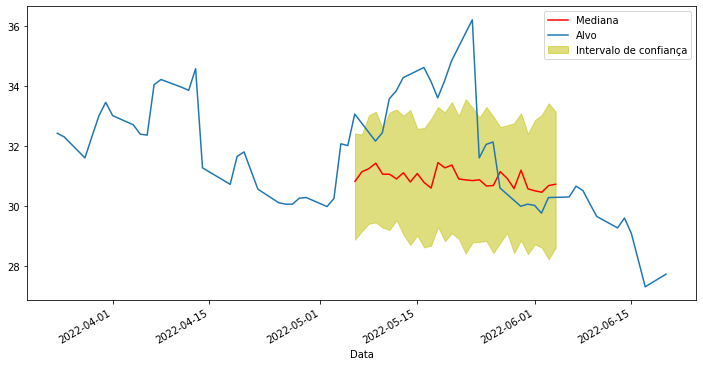

In [59]:
# Ploting the predictions

for k in range(len(previsoes)):
    plt.figure(figsize=(12,6))
    previsoes[k]['0.5'].plot(label = 'Mediana', color = 'red')
    #serie_temporal_teste[k].plot(label = 'Alvo')
    serie_temporal_teste[k][-prediction_length - context_length:].plot(label = 'Alvo')
    p10 = previsoes[k]['0.1']
    p90 = previsoes[k]['0.9']
    plt.fill_between(p10.index, p10, p90, color = 'y', alpha = 0.5, label = 'Intervalo de confiança')
    plt.legend()
    plt.show()

In [60]:
# With the predictions and the targets wer can calculate the associated error.

previsoes2 = previsoes[0]['0.5'].values
previsoes2

array([30.81745529, 31.13921165, 31.24145699, 31.4236145 , 31.05799484,
       31.05731201, 30.90120697, 31.10475731, 30.79915237, 31.07999611,
       30.78135681, 30.59641075, 31.44280815, 31.26982117, 31.36137772,
       30.8988018 , 30.86815071, 30.84554482, 30.8707943 , 30.66443443,
       30.68188095, 31.14208221, 30.92032623, 30.58022118, 31.19200706,
       30.57136726, 30.50530434, 30.45682144, 30.67963028, 30.72378349])

In [65]:
df_teste = base.iloc[1227:,:]
len(df_teste)

30

In [66]:
esperado = df_teste['Último'].values
len(esperado)

30

In [67]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(esperado, previsoes2)
mse = mean_squared_error(esperado, previsoes2)
print('MAE: ', mae, '\nMSE: ', mse)

MAE:  1.7659991099066663 
MSE:  4.780899030271785


In [72]:
from sagemaker import get_execution_role
session.delete_endpoint(endpoint)
